In [1]:
import numpy as np
import torch

import gpytorch
import botorch

from src.model import DerivativeExactGPSEModel

import matplotlib.pyplot as plt
%config Completer.use_jedi = False

In [2]:
objective_function = lambda x: -x**2 + (5*torch.sin(x*10/np.pi))
derivative_objective_func = lambda x: -2*x + 5*10/np.pi *np.cos(x*10/np.pi)

In [3]:
NOISE_SE = 0.25
train_x = 4 * torch.rand(5,1) - 2 
exact_obj = objective_function(train_x)
train_y = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
test_x = torch.linspace(-2, 2)

In [4]:
model = DerivativeExactGPSEModel(D=1, N_max=None)
model.append_train_data(train_x, train_y.squeeze())
# freeze hyperparameters
model.covar_module.base_kernel.lengthscale = 0.6
model.covar_module.outputscale = 24.
model.likelihood.noise = NOISE_SE

In [5]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 8,
    "font.size": 8,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
}

plt.rcParams.update(tex_fonts)
#plt.style.use('seaborn-white')

In [9]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 0.5

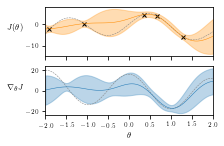

In [13]:
with torch.no_grad():
    fig, axs = plt.subplots(2, figsize=(3, 2), sharex=True)
    axs[0].plot(test_x, objective_function(test_x), 'gray',linestyle='--', label='Objective')
    axs[0].plot(model.train_inputs[0], model.train_targets, 'kx', markersize=3.5, label='Observed Data') 
    axs[1].plot(test_x, derivative_objective_func(test_x), 'gray', linestyle='--', label='Analytic Derivative')
    # Posterior of GP.
    posterior = model.posterior(test_x, observation_noise=True)
    lower, upper = posterior.mvn.confidence_region()
    axs[0].plot(test_x, posterior.mean, color='darkorange', label='Mean')
    axs[0].fill_between(test_x, lower, upper, color='darkorange', alpha=0.3, label='Confidence')
    # Posterior of derivative GP.
    mean_d, variance_d = model.posterior_derivative(test_x)
    mean_d, variance_d = mean_d.squeeze(), variance_d.squeeze()
    posterior_d = gpytorch.distributions.MultivariateNormal(mean_d, 
                                                            torch.eye(variance_d.shape[0]) * variance_d)
    lower_d, upper_d = posterior_d.confidence_region()
    axs[1].plot(test_x, mean_d, color='#1f77b4', label='Mean')
    axs[1].fill_between(test_x, lower_d, upper_d, color='#1f77b4', alpha=0.3, label='Confidence')
    # Labels.
    #axs[0].set_xlabel(r'$\theta$')
    axs[0].set_ylabel(r'$J(\theta)$', rotation=0, labelpad=10)
    axs[1].set_xlabel(r'$\theta$')
    axs[1].set_ylabel(r'$\nabla_\theta J$', rotation=0, labelpad=10)
    axs[0].margins(x=0)
    axs[1].margins(x=0)
    #fig.legend(loc='upper center', bbox_to_anchor=(0.52, 1.3), ncol=2)
    plt.savefig('/home/sarah/Downloads/test2.pdf', bbox_inches='tight')